In [1]:
import string
import pandas as pd
from collections import Counter
import numpy as np
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import contractions

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# Import du dataset

In [2]:
df = pd.read_parquet('./stack_overflow_v2.parquet')
df.head(10)

Title  \
0                             erasing on uiimageview   
1  how to avoid the "circular view path" exceptio...   
2  'cannot open git-upload-pack' error in eclipse...   
3  managing relationships in laravel, adhering to...   
4  how to implement `viewforheaderinsection` on i...   
5           xcode 5: code signing entitlement errors   
6  is there a way to assign a static ip to a aws ...   
7  apt-get is broken after install google cloud s...   
8  htaccess compare cookie value and redirect if ...   
9                 how to embed small icon in uilabel   

                                                Body        Id  \
0  <p>how can i erase content on front uiimage by...  18784475   
1  <p>i have the following code in one of my cont...  18813615   
2  <p>i am not able to clone or push to a git rep...  18813847   
3  <p>while creating an app in laravel 4 after re...  18817615   
4  <p>how to implement <code>(uiview *)tableview:...  18817841   
5  <p>i've build a new application which is going...  18818381   
6  <p>i am looking to assign a static ip to my la...  56676259   
7  <p>i was installing the google cloud sdk on my...  56679191   
8  <p>i would like somebody to help me with an if...  19382160   
9  <p>i need to embed small icons ( sort of custo...  19318421   

                                                Tags  Score  ViewCount  \
0       iphone ios objective-c uiimageview cgcontext     12       3768   
1  spring spring-mvc circular-reference thymeleaf...    151     271443   
2    eclipse git bitbucket egit atlassian-sourcetree     69     274616   
3  oop laravel laravel-4 repository-pattern eloquent    133      41842   
4           objective-c iphone uitableview ipad ios7     22      33861   
5        objective-c xcode macos code-signing xcode5    150      80186   
6  amazon-web-services aws-lambda aws-api-gateway...     22      25218   
7  unix ubuntu-18.04 apt-get unixodbc google-clou...     78      48327   
8         regex apache .htaccess mod-rewrite cookies     12      24780   
9           ios objective-c cocoa-touch ios7 textkit    186     140950   

   AnswerCount  FavoriteCount  
0            3            0.0  
1           24            0.0  
2           31            0.0  
3            4            0.0  
4            6            0.0  
5           21            0.0  
6            4            0.0  
7            6            0.0  
8            4            0.0  
9           21            0.0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57854 entries, 0 to 57853
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          57854 non-null  object 
 1   Body           57854 non-null  object 
 2   Id             57854 non-null  int64  
 3   Tags           57854 non-null  object 
 4   Score          57854 non-null  int64  
 5   ViewCount      57854 non-null  int64  
 6   AnswerCount    57854 non-null  int64  
 7   FavoriteCount  50769 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 3.5+ MB


In [4]:
df.describe(include=[object])

Title  \
count                    57854   
unique                   57854   
top     erasing on uiimageview   
freq                         1   

                                                     Body  \
count                                               57854   
unique                                              57854   
top     <p>how can i erase content on front uiimage by...   
freq                                                    1   

                                                    Tags  
count                                              57854  
unique                                             56716  
top     angular typescript ionic-framework ionic2 ionic3  
freq                                                  24

# Utility function

In [5]:
def wordcloud_fig(text):
    wordcloud = WordCloud(max_font_size=40, max_words=50, background_color="white").generate(" ".join(i for i in text))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def plot_words(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.boxplot(data=col.str.len(), ax=axes[0])
    axes[0].set_title("Boxplot")
    sns.histplot(data=col.str.len(), ax=axes[1])
    axes[1].set_title("Distplot")
    plt.suptitle(f"Distribution de {col.name}", fontsize=22)
    plt.show()

def plot_sentences(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.boxplot(data=col.str.split('.').str.len(), ax=axes[0])
    axes[0].set_title("Boxplot of sentences")
    sns.histplot(data=col.str.split('.').str.len(), ax=axes[1])
    axes[1].set_title("Distplot of sentences")
    plt.suptitle(f"Distribution de {col.name}", fontsize=22)
    plt.show()

def remove_html_tags(col):
    return BeautifulSoup(col, "lxml").text

def text_to_lower(text):
    return text.lower()

def common_rare_words(dataframe_col):

    cnt = Counter()
    for text in dataframe_col.values:
        for word in text.split():
            cnt[word] += 1
    temp_df = pd.DataFrame(cnt.most_common(), columns=["Word", "Freq"])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.barplot(data=temp_df.head(10), y="Word", x="Freq", ax=axes[0])
    axes[0].set_title("Boxplot")
    sns.barplot(data=temp_df.tail(10), y="Word", x="Freq", ax=axes[1])
    axes[1].set_title("Distplot")
    plt.suptitle(f"Distribution de {dataframe_col.name}", fontsize=22)
    plt.show()

In [6]:
def decontracted_text(text):
    return contractions.fix(text)


def remove_punctuations(text):
    remove = string.punctuation
    remove = remove.replace("#", "") # don't c#
    remove = remove.replace("+", "") # don't remove c++
    pattern = r"[{}](?!net)".format(re.escape(remove))
    return re.sub(pattern, "", text)


def word_lemmatizer(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    return ' '.join([wordnet_lemmatizer.lemmatize(w, pos="v") for w in text.split()])



def remove_aplhanum(text):
    return ''.join(i for i in text if not i.isdigit())


def remove_stopwords_nltk(text):
    return ' '.join([w for w in text.split() if w not in stopwords.words("english")])

# EDA avant traitement

## Nettoyage des tags html

In [7]:
df["Tags"] = df["Tags"].str.lstrip('<').str.replace('<', ' ').str.replace('>', '')
df['Body'] = df['Body'].apply(lambda x :remove_html_tags(x))
df['Body'] = df['Body'].apply(lambda x :text_to_lower(x))
df['Title'] = df['Title'].apply(lambda x :text_to_lower(x))

# Exploring Title

In [8]:
# making sure there is no duplicated
df.loc[ df['Title'].duplicated(keep=False), : ]

Empty DataFrame
Columns: [Title, Body, Id, Tags, Score, ViewCount, AnswerCount, FavoriteCount]
Index: []

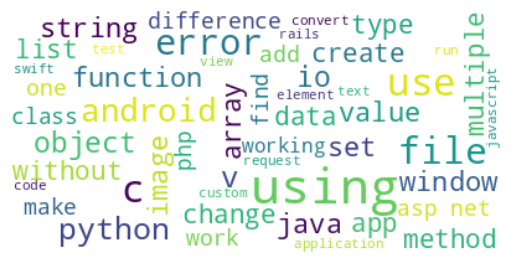

In [9]:
wordcloud_fig(df['Title'])

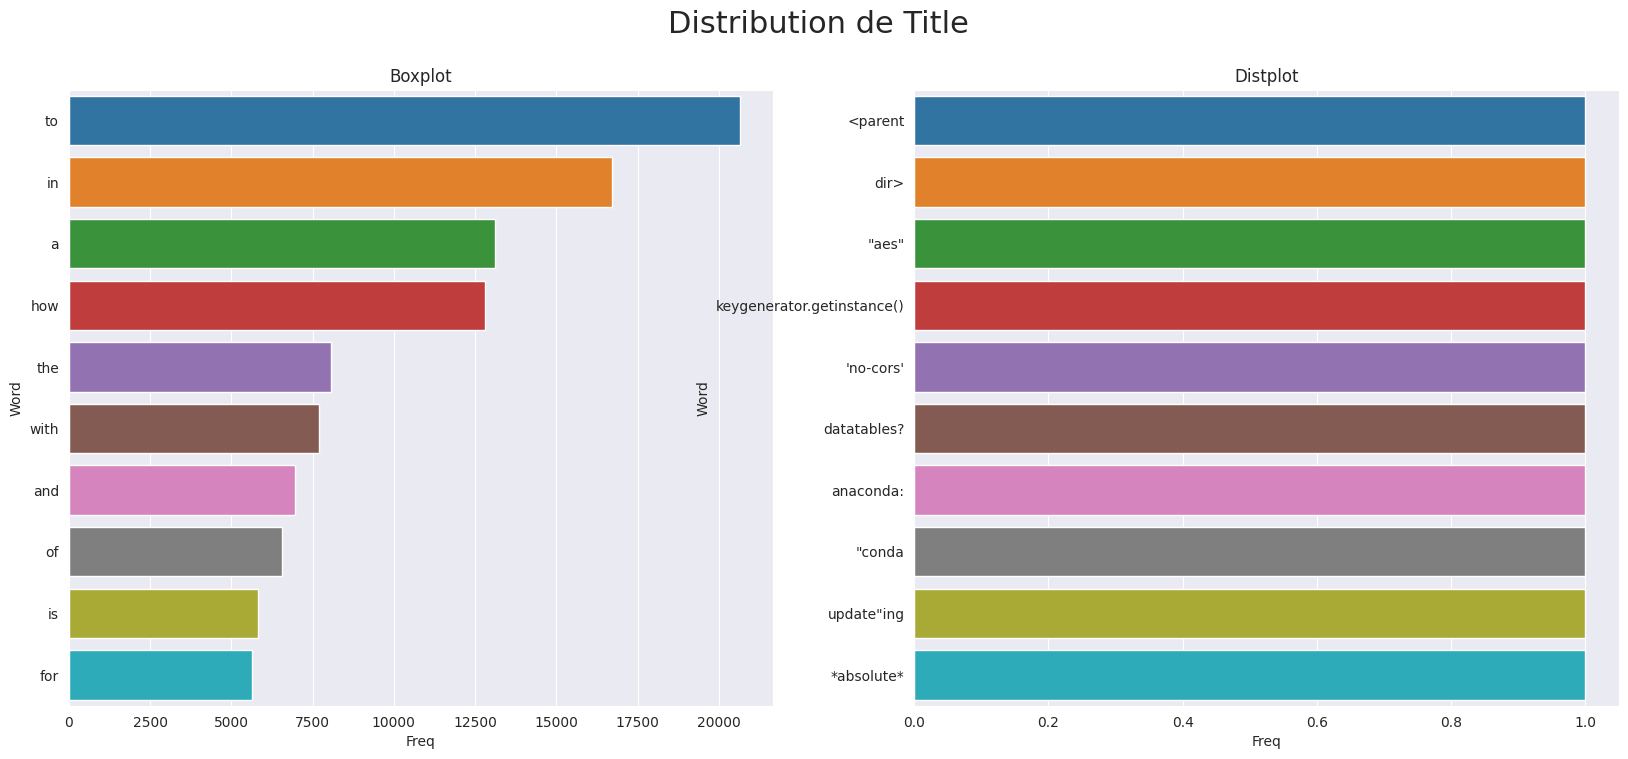

In [10]:
common_rare_words(df["Title"])

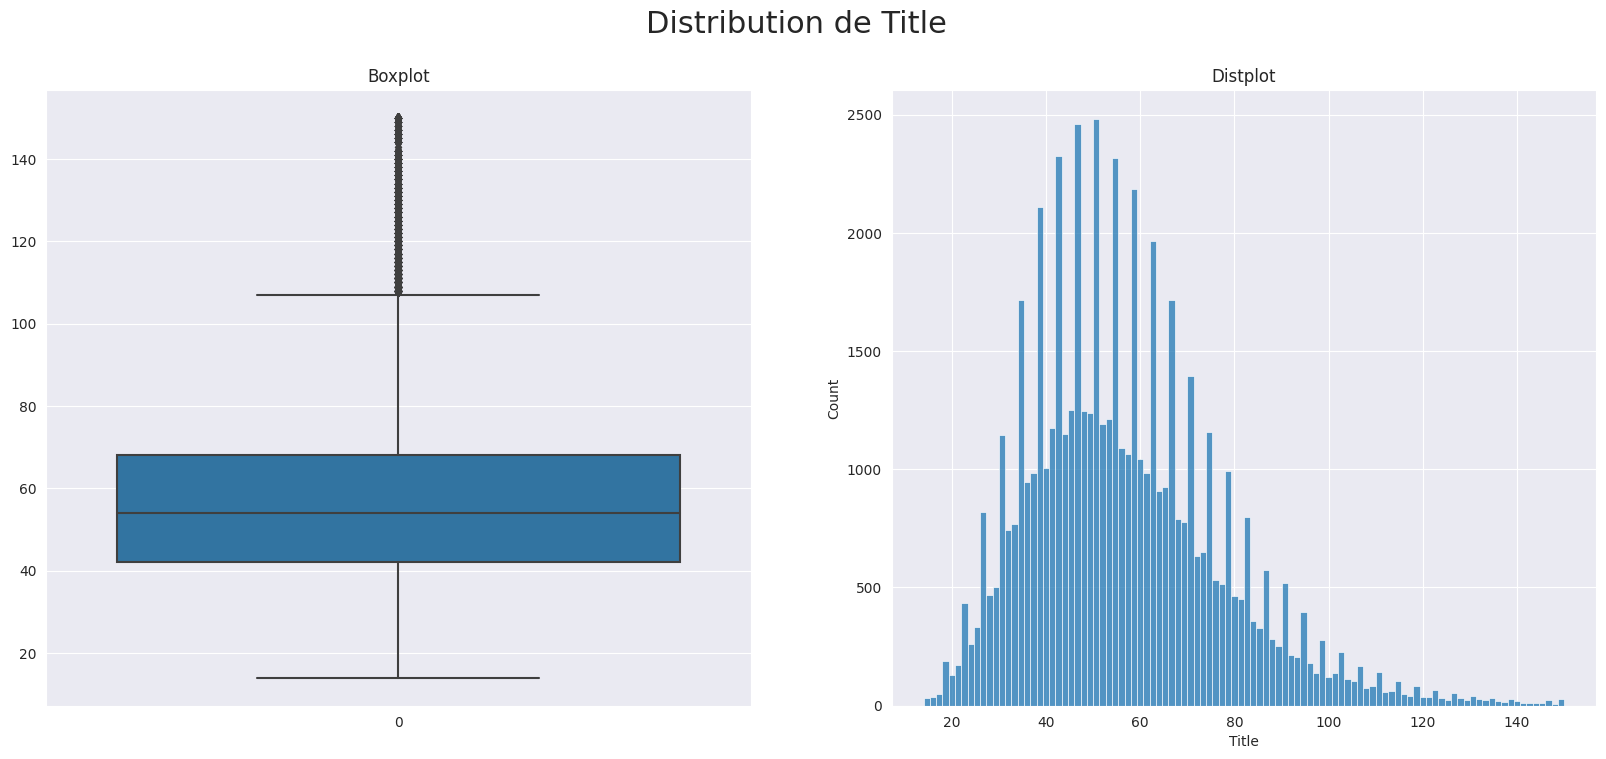

In [11]:
plot_words(df['Title'])

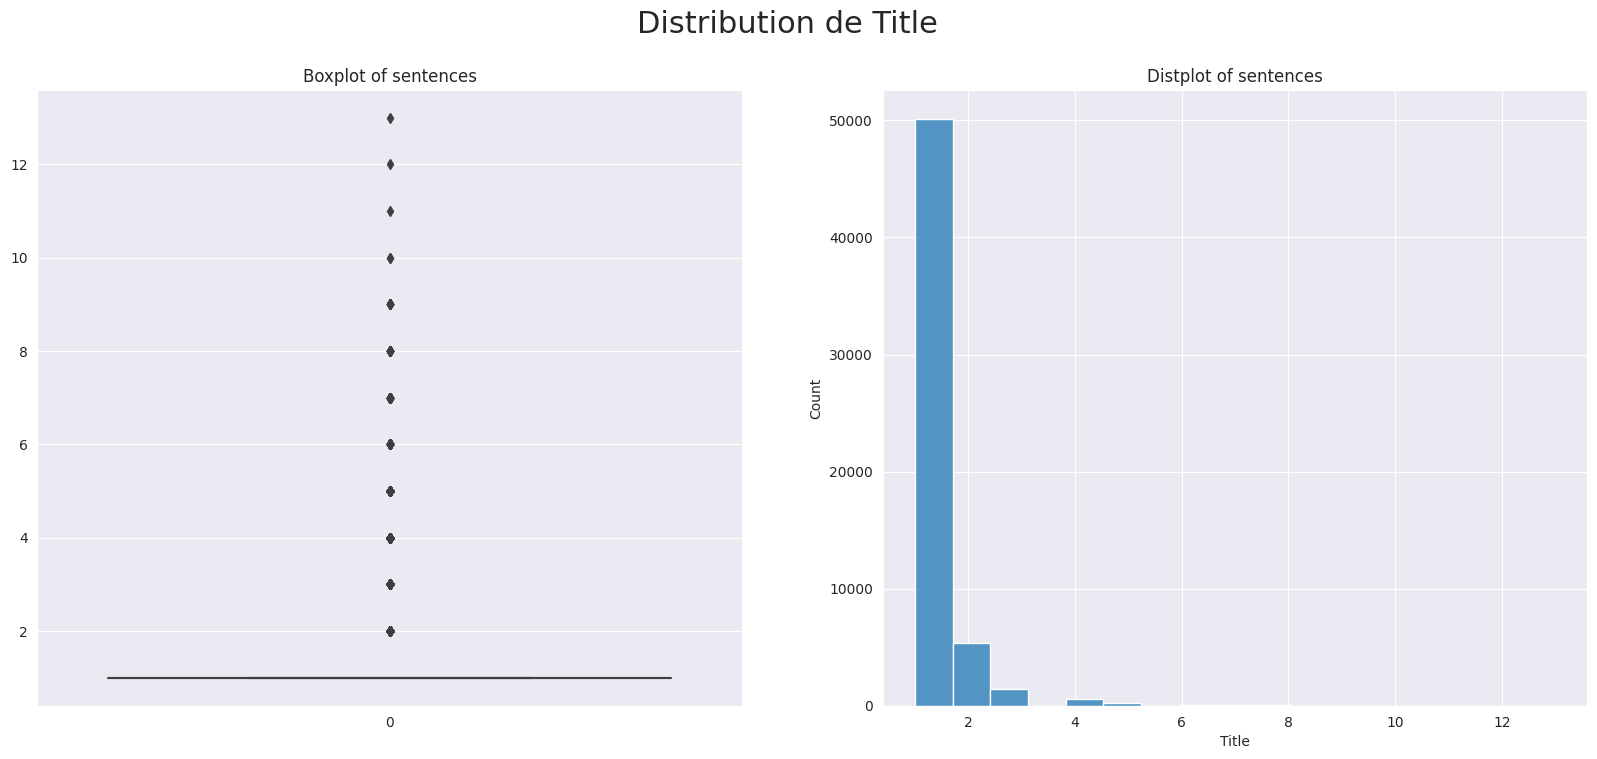

In [12]:
plot_sentences(df['Title'])

# Exploring Body

In [13]:
# making sure there is no duplicated
df.loc[ df['Body'].duplicated(keep=False), : ]

Empty DataFrame
Columns: [Title, Body, Id, Tags, Score, ViewCount, AnswerCount, FavoriteCount]
Index: []

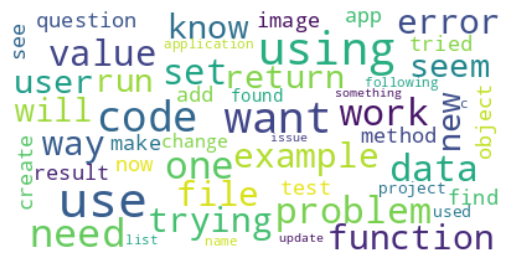

In [14]:
wordcloud_fig(df['Body'])

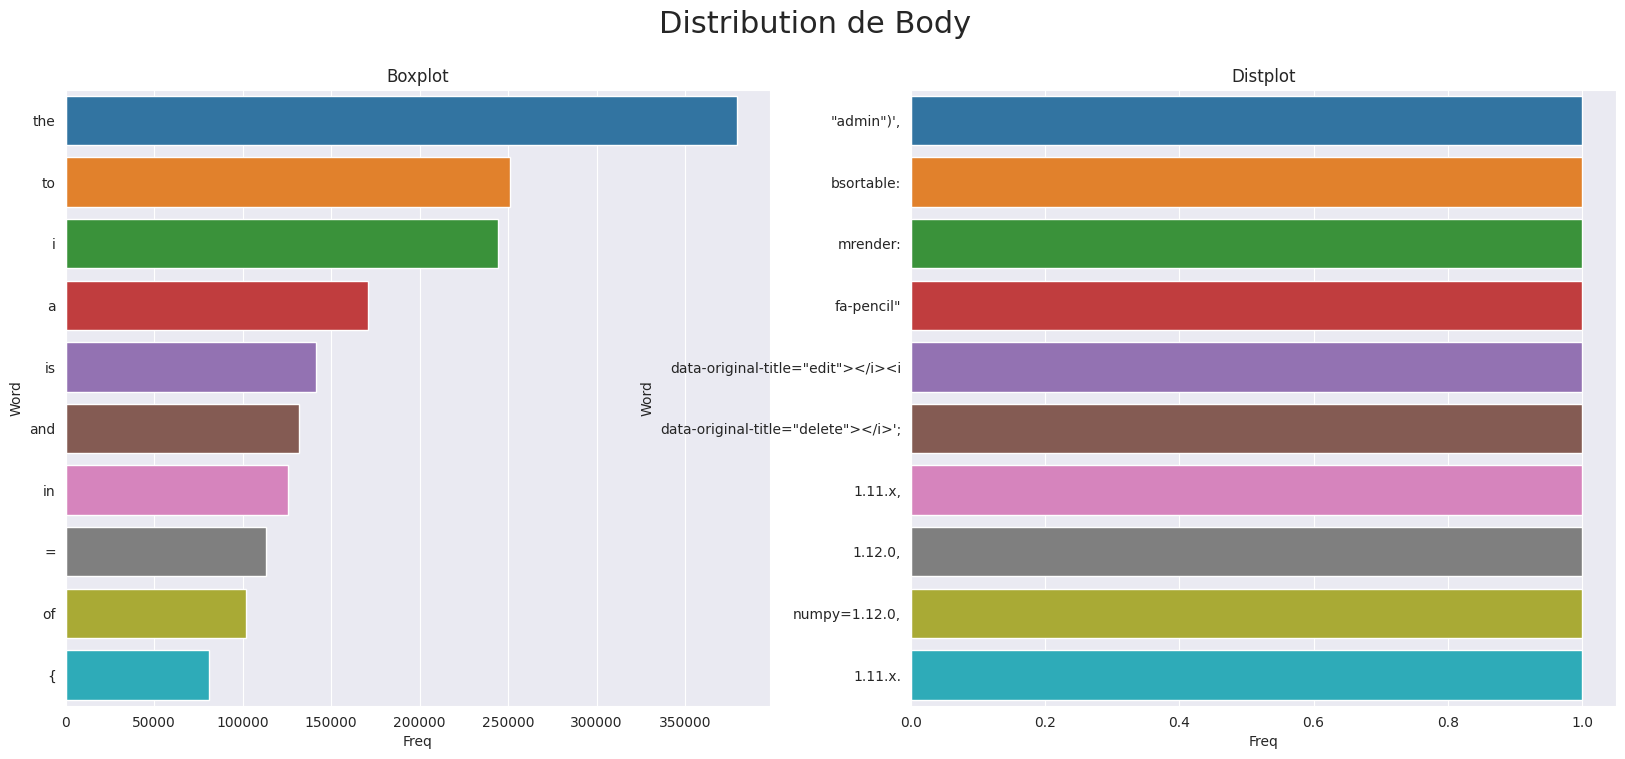

In [15]:
common_rare_words(df['Body'])

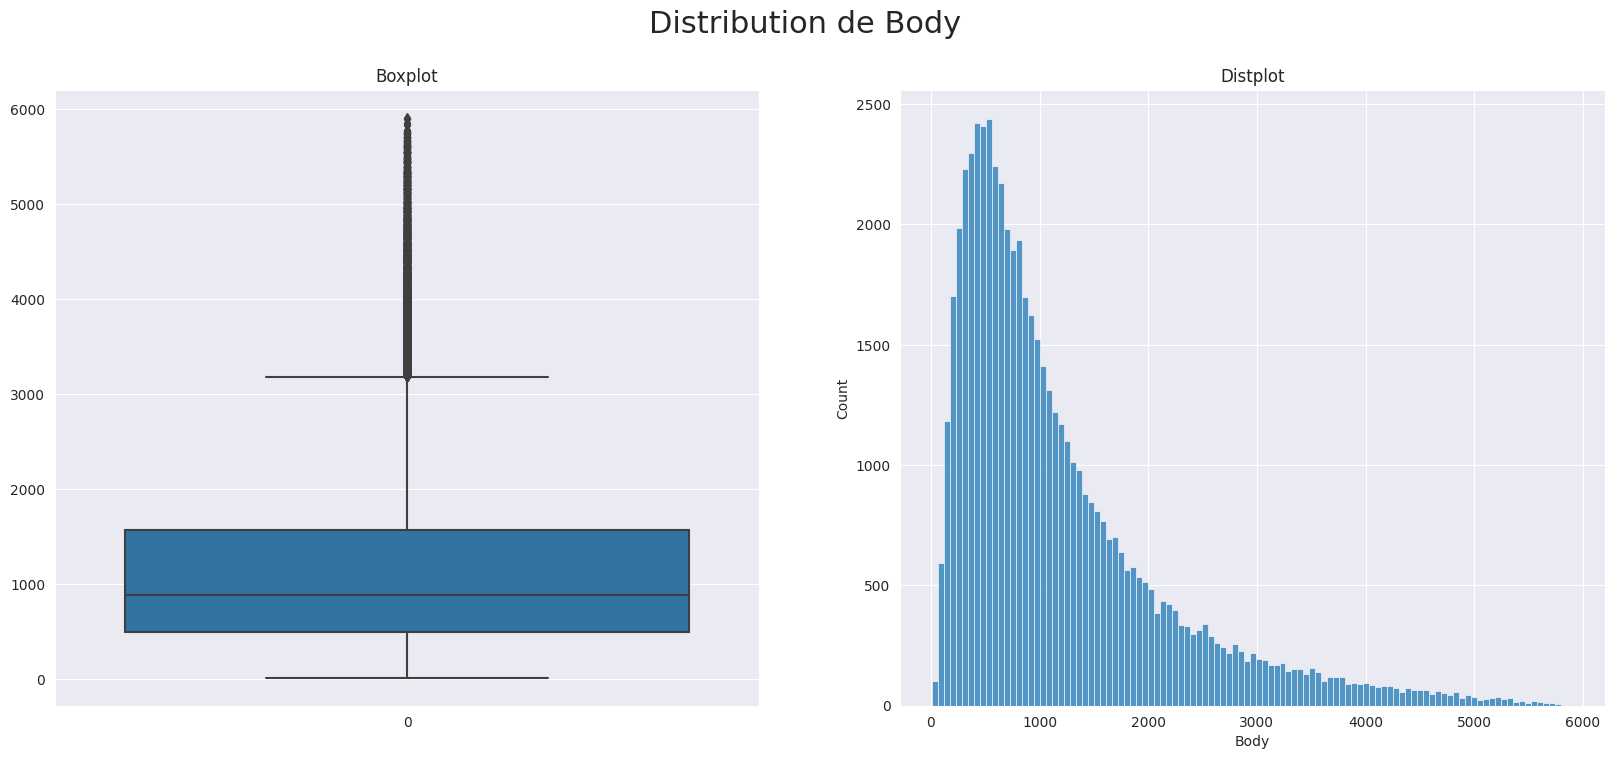

In [16]:
plot_words(df['Body'])

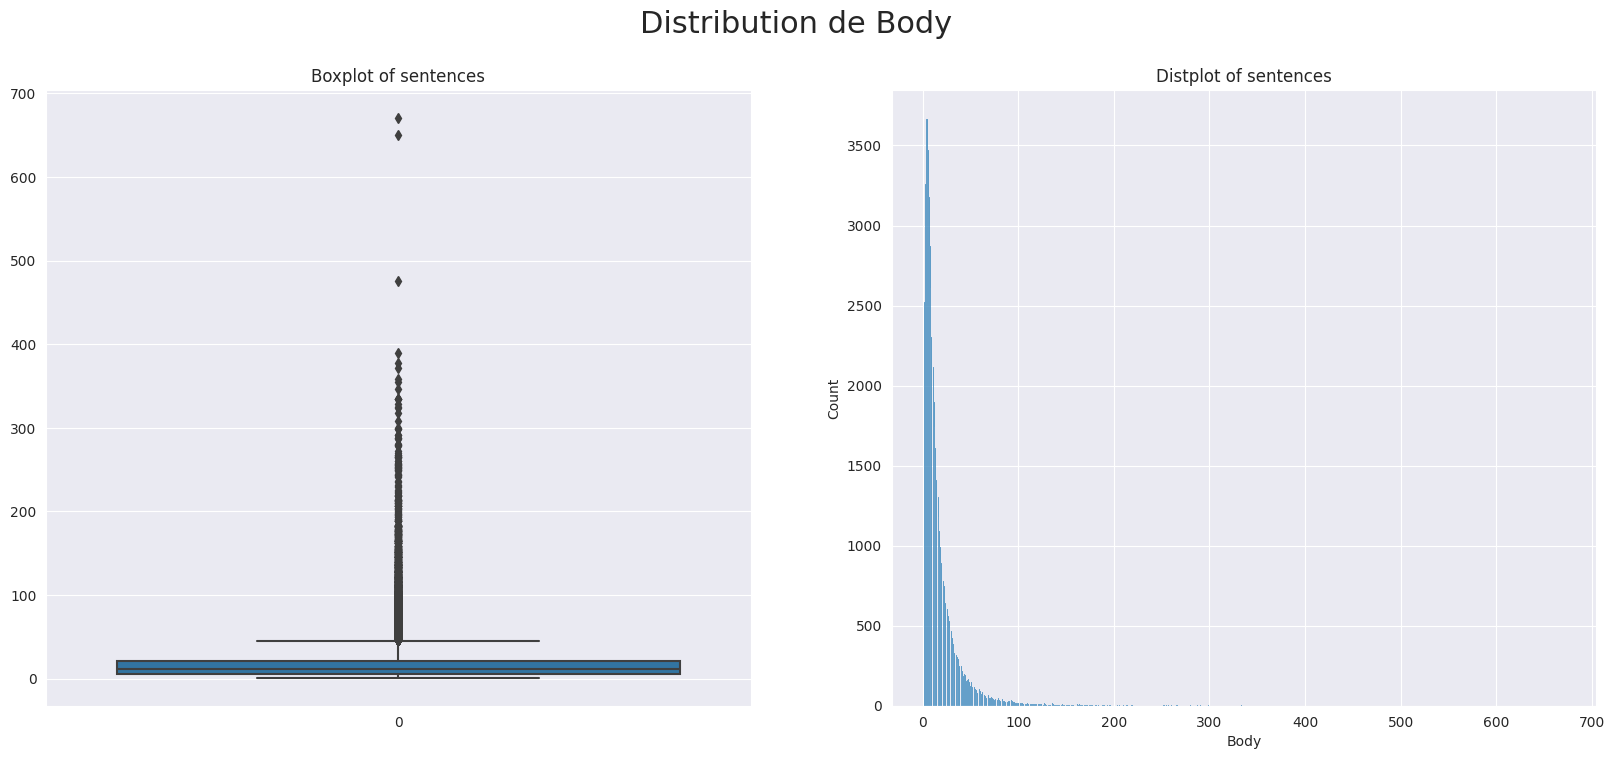

In [17]:
plot_sentences(df['Body'])

# Exploring tags

In [18]:
df.loc[df['Tags'].duplicated(keep=False), : ]

Title  \
11          laravel eloquent get results grouped by days   
109    how do i pass a swift object to javascript (wk...   
128                bash tool to get nth line from a file   
139                  adding a target to an xcode project   
265     find index of maximum element in x86 simd vector   
...                                                  ...   
57756  how to split a dataset into training and valid...   
57811  what is the correct way to use entity framewor...   
57821                     batch-major vs time-major lstm   
57832  model help using scikit-learn when using grids...   
57848   expand collapse list item using angular material   

                                                    Body        Id  \
11     i currently have a table of page_views that re...  20603075   
109    i am working on passing data from swift to jav...  32113933   
128    is there a "canonical" way of doing that? i've...   6022384   
139    i have an iphone application which is currentl...   7409127   
265    i'm thinking of implementing 8-ary heapsort fo...  23590610   
...                                                  ...       ...   
57756  i have a multi class classification problem an...  29082001   
57811  i tried setting datasource via datagridview de...  42114690   
57821  do rnns learn different dependency patterns wh...  42130491   
57832  as part of the enron project, built the attach...  42362027   
57848  can anyone give any suggestions for adding an ...  42372053   

                                                    Tags  Score  ViewCount  \
11                       php mysql sql laravel laravel-4     63     156727   
109                        ios iphone xcode swift swift2     12      18664   
128                              bash shell unix awk sed    823     658986   
139                    iphone objective-c ios xcode ios4     11       9961   
265                                 c++ x86 sse simd avx     14       6295   
...                                                  ...    ...        ...   
57756  python numpy pandas machine-learning scikit-learn     19      24216   
57811     c# .net winforms entity-framework datagridview     19      28079   
57821  python tensorflow deep-learning lstm recurrent...      8       4304   
57832  python machine-learning scikit-learn cross-val...      6       6359   
57848     javascript html css angularjs angular-material      6      17095   

       AnswerCount  FavoriteCount  
11              17            0.0  
109              5            0.0  
128             22            0.0  
139              3            0.0  
265              3            0.0  
...            ...            ...  
57756            2            0.0  
57811            2            0.0  
57821            2            0.0  
57832            2            0.0  
57848            2            0.0  

[1900 rows x 8 columns]

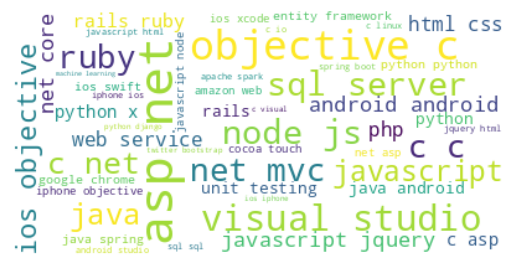

In [19]:
wordcloud_fig(df['Tags'])

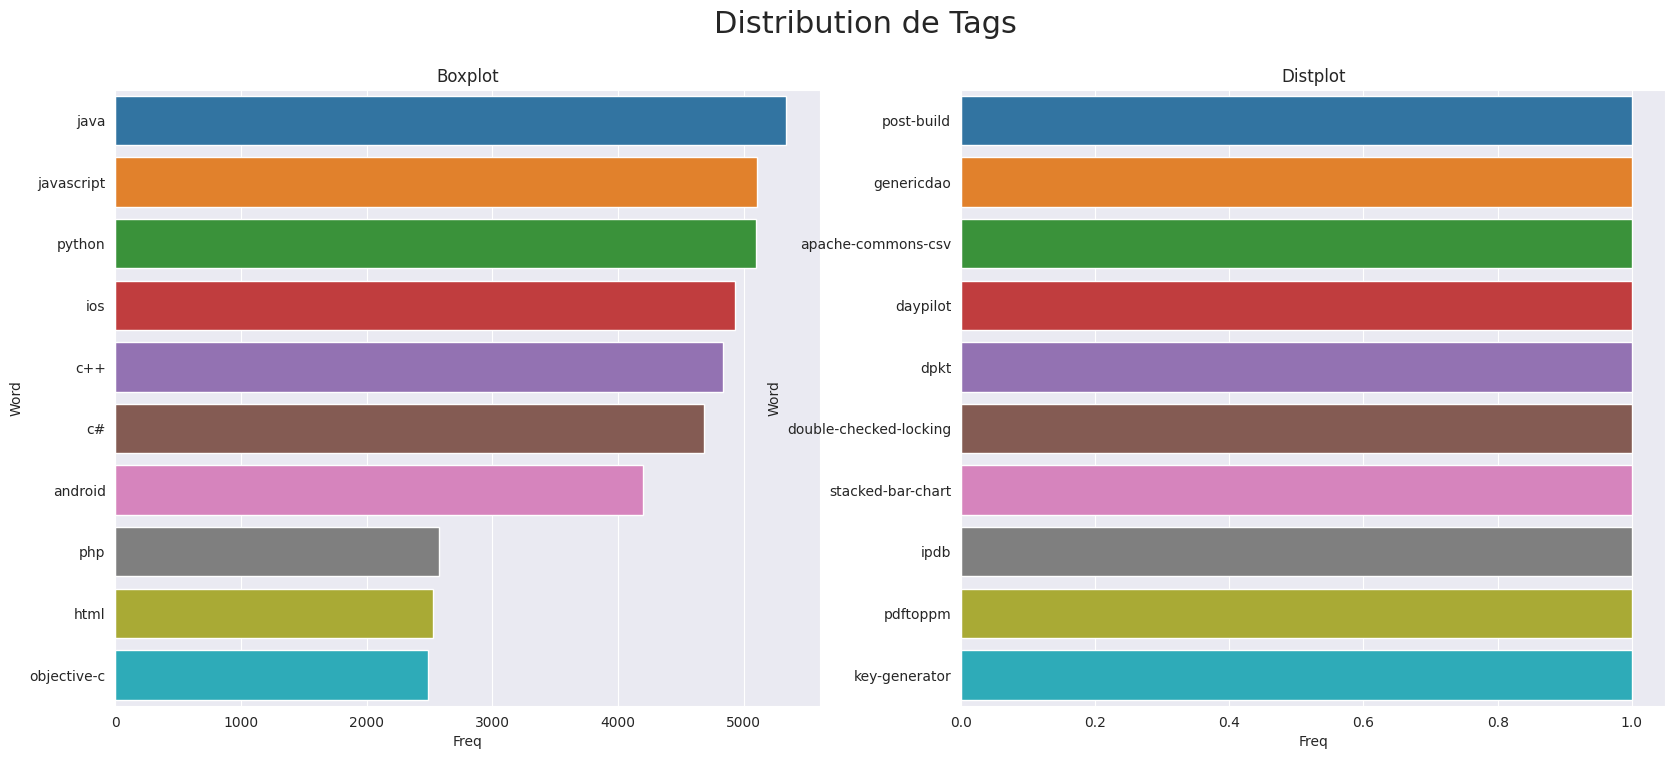

In [20]:
common_rare_words(df['Tags'])

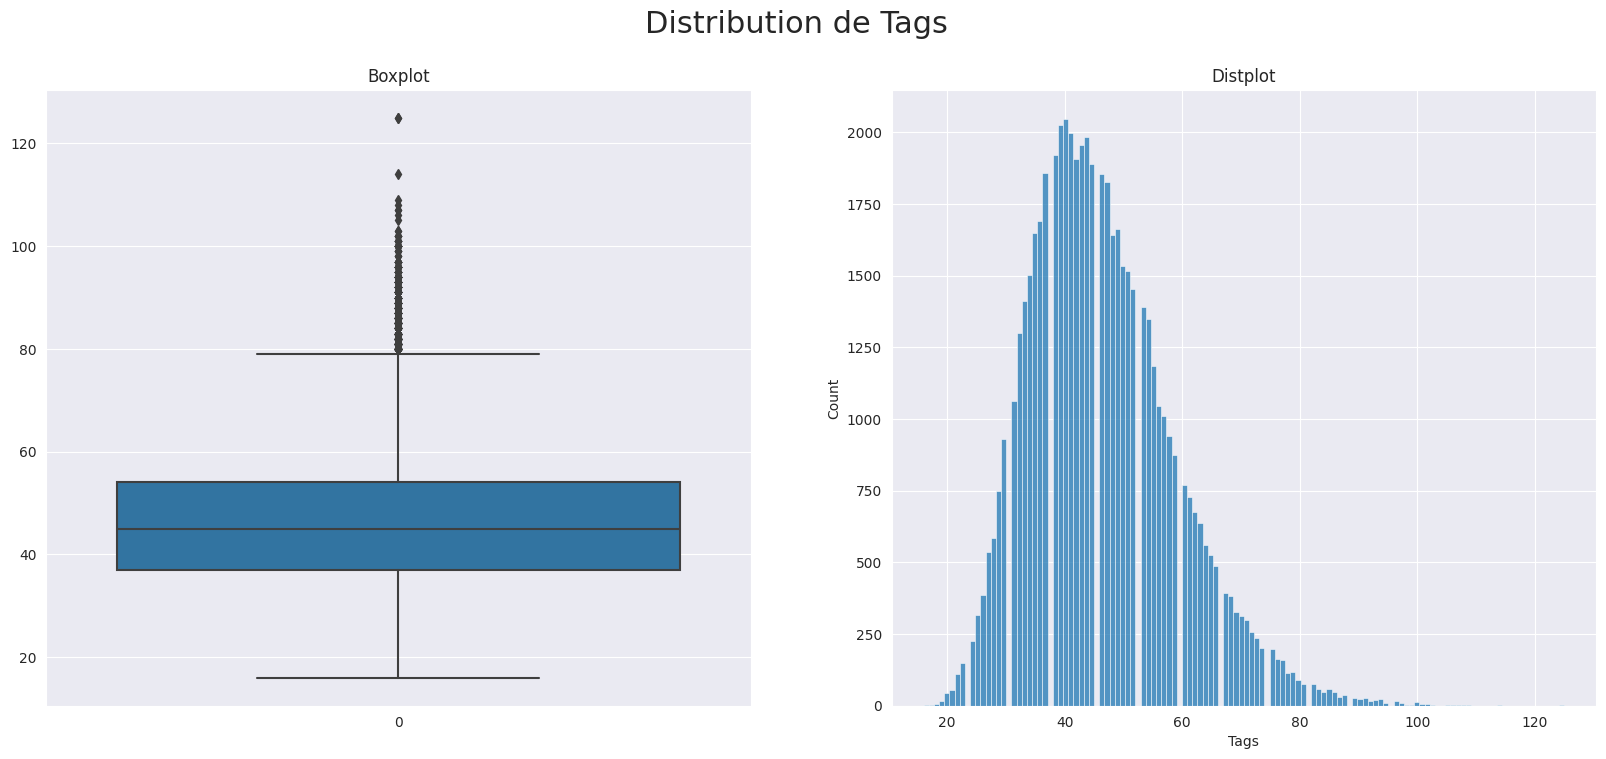

In [21]:
plot_words(df['Tags'])

In [22]:
df["Tags"]

0             iphone ios objective-c uiimageview cgcontext
1        spring spring-mvc circular-reference thymeleaf...
2          eclipse git bitbucket egit atlassian-sourcetree
3        oop laravel laravel-4 repository-pattern eloquent
4                 objective-c iphone uitableview ipad ios7
                               ...                        
57849            javascript reactjs cors fiddler fetch-api
57850    javascript haskell functional-programming reac...
57851                       python rest timeout wsgi uwsgi
57852    c# jquery asp.net-mvc twitter-bootstrap datata...
57853               python numpy anaconda conda python-3.6
Name: Tags, Length: 57854, dtype: object

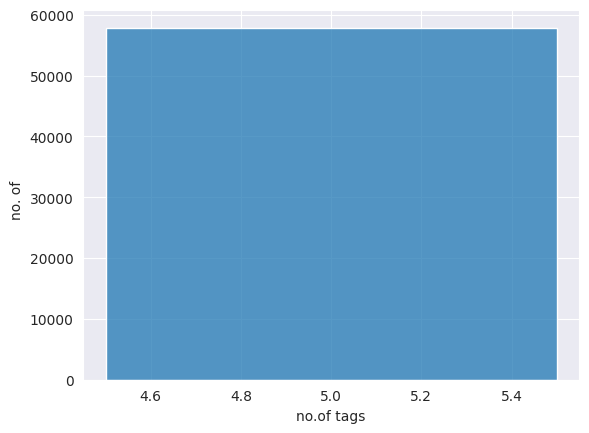

In [23]:
sns.histplot(df["Tags"].apply(lambda text: len(str(text).split(" "))))
plt.ylabel('no. of  ')
plt.xlabel('no.of tags')
plt.show()

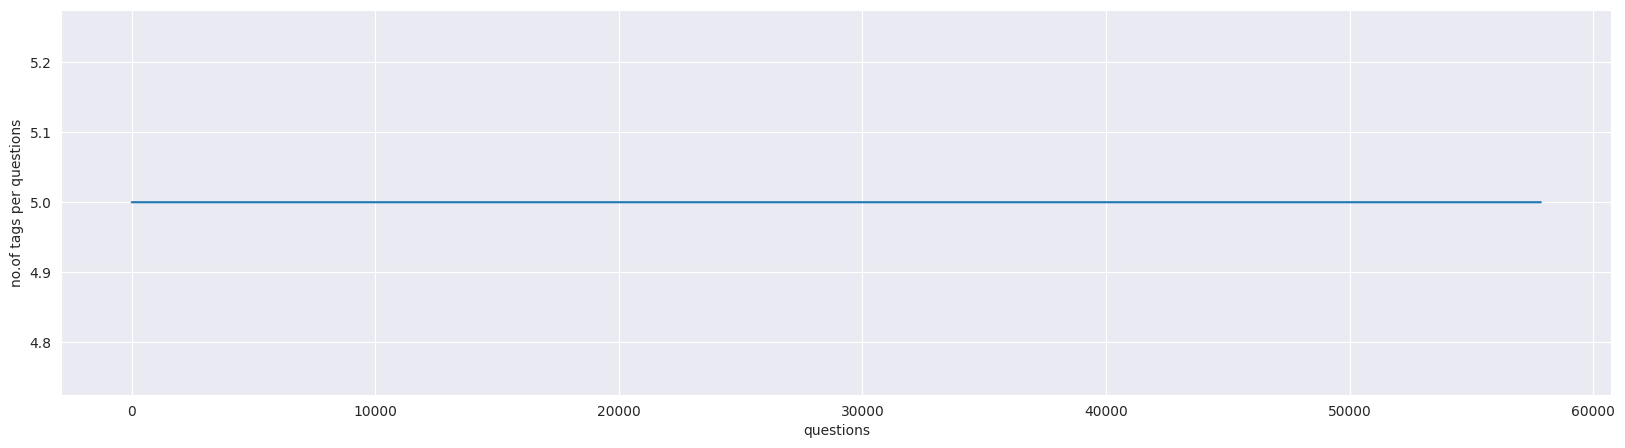

In [24]:
plt.figure(figsize=(20,5))
plt.plot(df["Tags"].apply(lambda text: len(str(text).split(" "))))
plt.xlabel('questions')
plt.ylabel("no.of tags per questions")
plt.show()

In [25]:
# sns.countplot(df["Tags"].apply(lambda text: len(str(text).split(" "))).value_counts())
# plt.ylabel('% of tags in questions')
# plt.xlabel('no.of tags')
# plt.show()

In [26]:
df["Tags"].apply(lambda text: len(str(text).split(" "))).describe()

count    57854.0
mean         5.0
std          0.0
min          5.0
25%          5.0
50%          5.0
75%          5.0
max          5.0
Name: Tags, dtype: float64

In [27]:
# plt.figure(figsize=(12,15))
# ax = sns.barplot(data=df, x=df["Tags"].apply(lambda text: len(str(text).split(" "))).value_counts(), y = "Tags")
# ax.set(ylabel = 'Count')
# plt.show()

In [28]:
# vectorizer = CountVectorizer(preprocessor=lambda x: x,tokenizer = lambda x: str(x).split(" ") )
# tag_vect = vectorizer.fit_transform(data["Tags"])
# def tags_to_choose(n):
#     t = tag_vect.sum(axis=0).tolist()[0]
#     sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
#     multilabel_yn = tag_vect[:, sorted_tags_i[:n]]
#     return multilabel_yn
#
#
# def questions_explained_fn(n):
#     multilabel_yn = tags_to_choose(n)
#     x = multilabel_yn.sum(axis=1)
#     return (np.count_nonzero(x == 0))


# questions_explained = []
# total_tags = tag_vect.shape[1]
# total_qs = data.shape[0]
# for i in range(total_tags):
#     questions_explained.append(np.round(((total_qs - questions_explained_fn(i)) / total_qs) * 100, 3))
# fig, ax = plt.subplots()
# ax.plot(questions_explained)
# plt.xlabel("Number of tags")
# plt.ylabel("Number Questions coverd partially")
# plt.grid()
# plt.show()

In [29]:
df.groupby('Tags').count()

Title  Body  Id  Score  \
Tags                                                                         
.htaccess cakephp passwords password-protection...      1     1   1      1   
.htaccess fonts cors font-face webfonts                 1     1   1      1   
.htaccess mod-rewrite redirect slash trailing-s...      1     1   1      1   
.htaccess mod-rewrite ssl heroku load-balancing         1     1   1      1   
.htaccess nginx url-rewriting angular-ui-router...      1     1   1      1   
...                                                   ...   ...  ..    ...   
zend-framework redirect plugins request response        1     1   1      1   
zend-framework warnings while-loop variable-ass...      1     1   1      1   
zend-framework web-applications dns saas wildca...      1     1   1      1   
zend-framework2 zend-form zend-form2 zend-form-...      1     1   1      1   
zooming selection jfreechart element area               1     1   1      1   

                                                    ViewCount  AnswerCount  \
Tags                                                                         
.htaccess cakephp passwords password-protection...          1            1   
.htaccess fonts cors font-face webfonts                     1            1   
.htaccess mod-rewrite redirect slash trailing-s...          1            1   
.htaccess mod-rewrite ssl heroku load-balancing             1            1   
.htaccess nginx url-rewriting angular-ui-router...          1            1   
...                                                       ...          ...   
zend-framework redirect plugins request response            1            1   
zend-framework warnings while-loop variable-ass...          1            1   
zend-framework web-applications dns saas wildca...          1            1   
zend-framework2 zend-form zend-form2 zend-form-...          1            1   
zooming selection jfreechart element area                   1            1   

                                                    FavoriteCount  
Tags                                                               
.htaccess cakephp passwords password-protection...              1  
.htaccess fonts cors font-face webfonts                         1  
.htaccess mod-rewrite redirect slash trailing-s...              1  
.htaccess mod-rewrite ssl heroku load-balancing                 1  
.htaccess nginx url-rewriting angular-ui-router...              1  
...                                                           ...  
zend-framework redirect plugins request response                1  
zend-framework warnings while-loop variable-ass...              1  
zend-framework web-applications dns saas wildca...              1  
zend-framework2 zend-form zend-form2 zend-form-...              0  
zooming selection jfreechart element area                       1  

[56716 rows x 7 columns]

# pre-processing the data

In [30]:
data = df.copy()

## processing title

In [31]:
data["Title"].sample(10)

15292    how to block disposable email addresses in you...
12616    bug : theme.translucent & flag_activity_reorde...
42669    event-sourcing with akka-persistance: growing ...
46830               programmatically expand sub jmenuitems
28505    how to convert a javascript object to utf-8 bl...
10754    does using large libraries inherently make slo...
56469    recompile the java files which is decompiled b...
7737     how can i convert a sql server 2008 datetimeof...
14614            using css @font-face with the ipad/iphone
4979     can i use css to add a bullet point to any ele...
Name: Title, dtype: object

In [32]:
data["Title"] = data["Title"].apply(lambda x :decontracted_text(x))

In [33]:
data["Title"] = data["Title"].apply(lambda x : remove_punctuations(x))

In [34]:
data["Title"] = data["Title"].apply(lambda x : remove_aplhanum(x))

In [35]:
data["Title"] = data["Title"].apply(lambda x : remove_stopwords_nltk(x))

In [36]:
data["Title"] = data["Title"].apply(lambda x : word_lemmatizer(x))

In [37]:
X_title = data["Title"]

In [38]:
X_title

0                                        erase uiimageview
1        avoid circular view path exception spring mvc ...
2        cannot open gituploadpack error eclipse clone ...
3        manage relationships laravel adhere repository...
4               implement viewforheaderinsection ios style
                               ...                        
57849    request header set expect use nocors mode fetc...
57850      implement haskells frp behavior type javascript
57851                    fix break pipe error uwsgi python
57852    possible place edit delete button jquery datat...
57853    anaconda way indicate dependency issue prevent...
Name: Title, Length: 57854, dtype: object

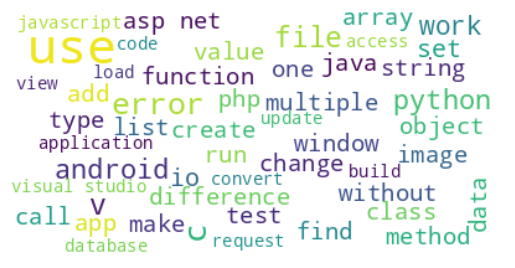

In [39]:
wordcloud_fig(X_title)

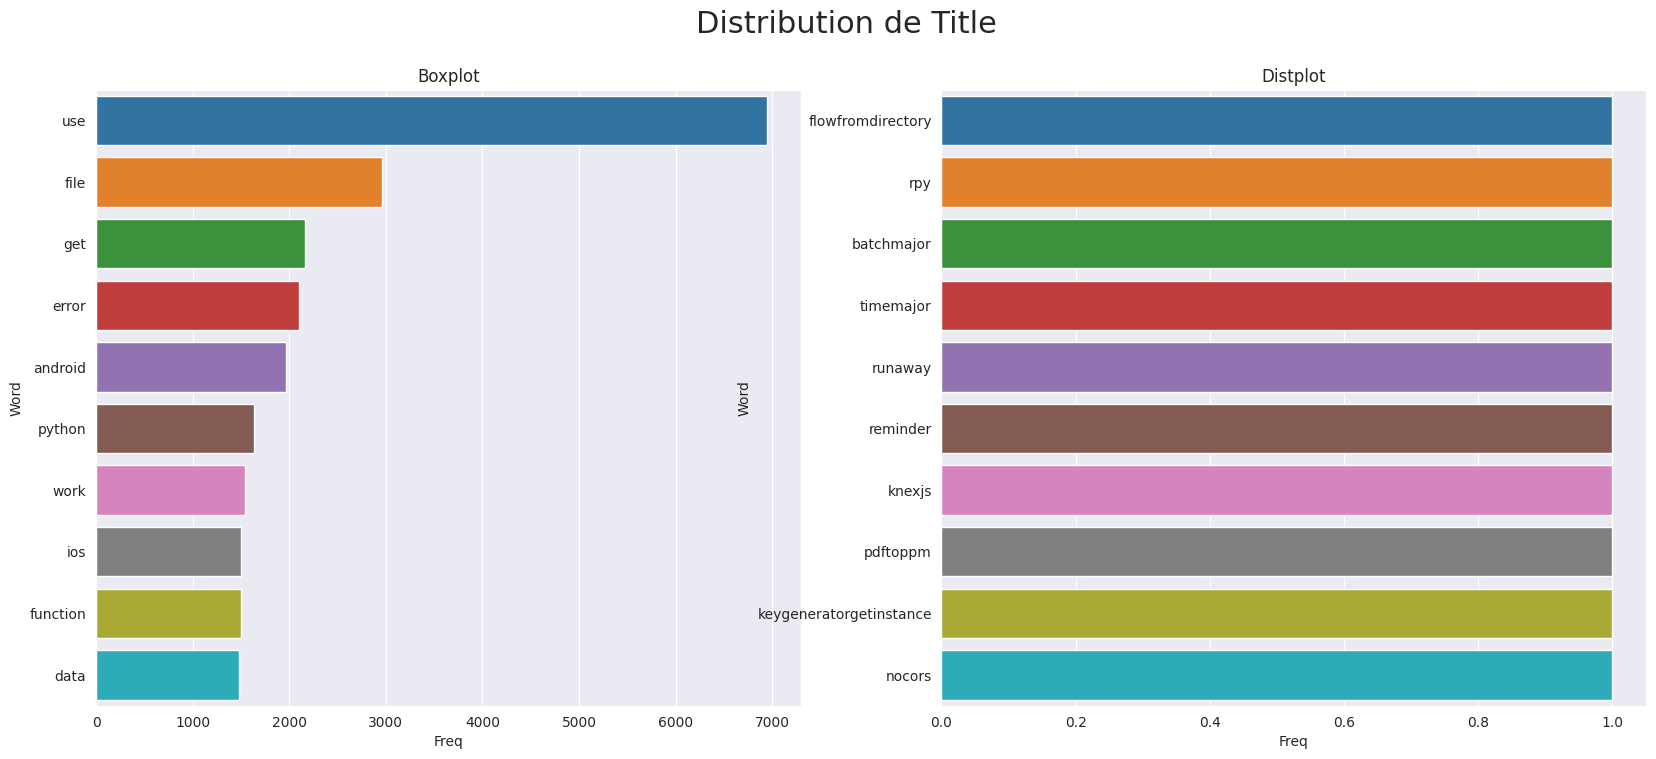

In [40]:
common_rare_words(X_title)

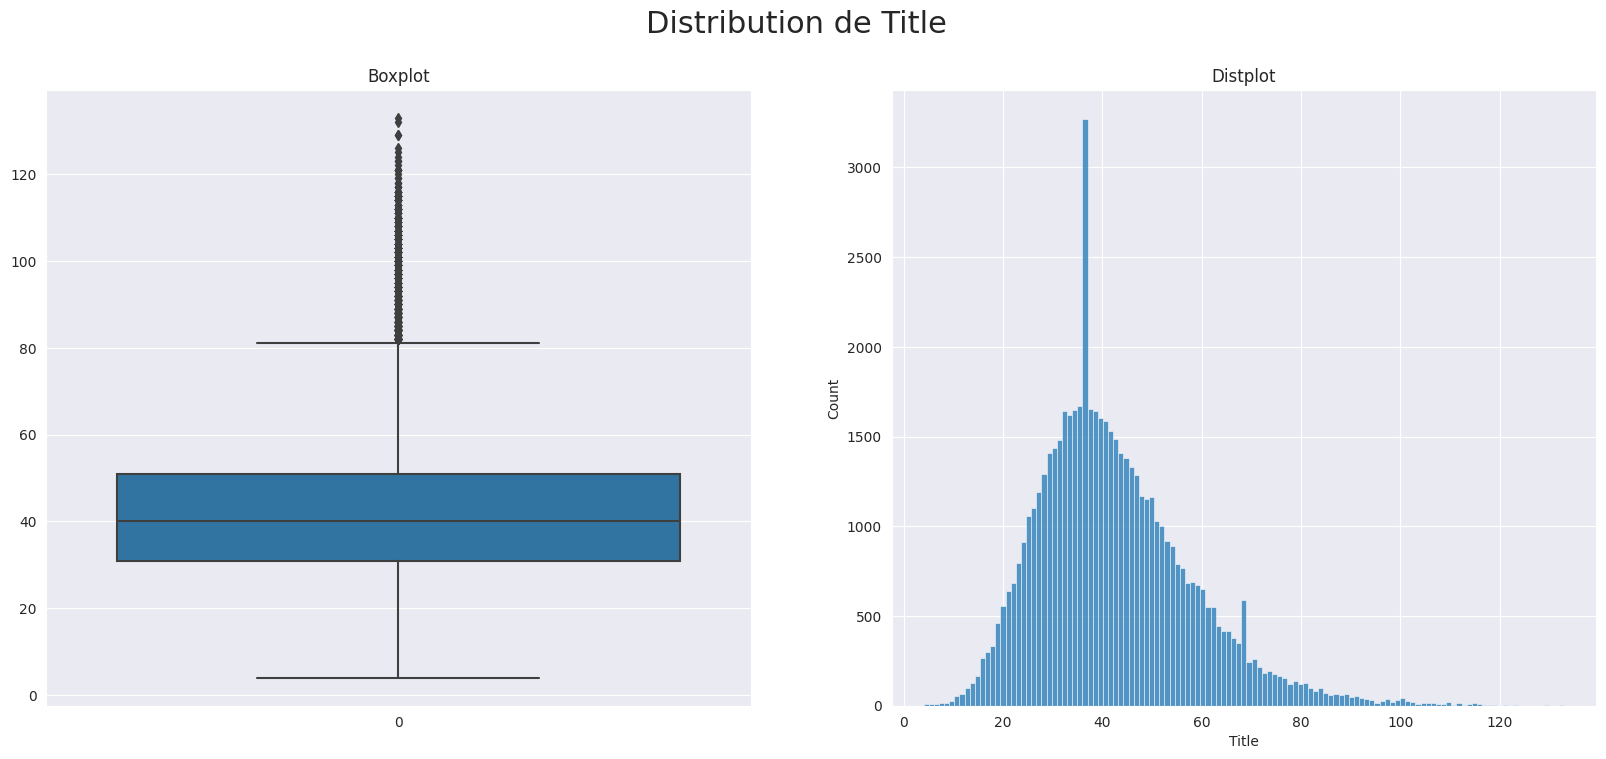

In [41]:
plot_words(X_title)

## processing body

In [42]:
data["Body"] = data["Body"].apply(lambda x: decontracted_text(x))

In [43]:
data["Body"] = data["Body"].apply(lambda x: remove_punctuations(x))

In [44]:
data["Body"] = data["Body"].apply(lambda x: remove_aplhanum(x))

In [45]:
data["Body"] = data["Body"].apply(lambda x: remove_stopwords_nltk(x))

In [46]:
data["Body"] = data["Body"].apply(lambda x: word_lemmatizer(x))

In [47]:
X_body = data["Body"]

In [48]:
X_body

0        erase content front uiimage swipe finger displ...
1        follow code one controllers controller request...
2        able clone push git repository bitbucket eclip...
3        create app laravel read otwells book good desi...
4        implement uiview tableviewuitableview tablevie...
                               ...                        
57849    fetch request type seem change mess post submi...
57850    would like understand original mean functional...
57851    hit rest resource myresource python uwsgi serv...
57852    beginner use jquery datatable try place edit d...
57853    recently discover numpy installation macos ana...
Name: Body, Length: 57854, dtype: object

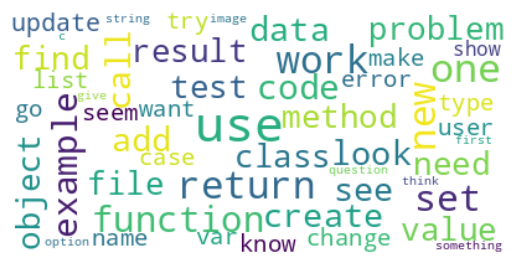

In [49]:
wordcloud_fig(X_body)

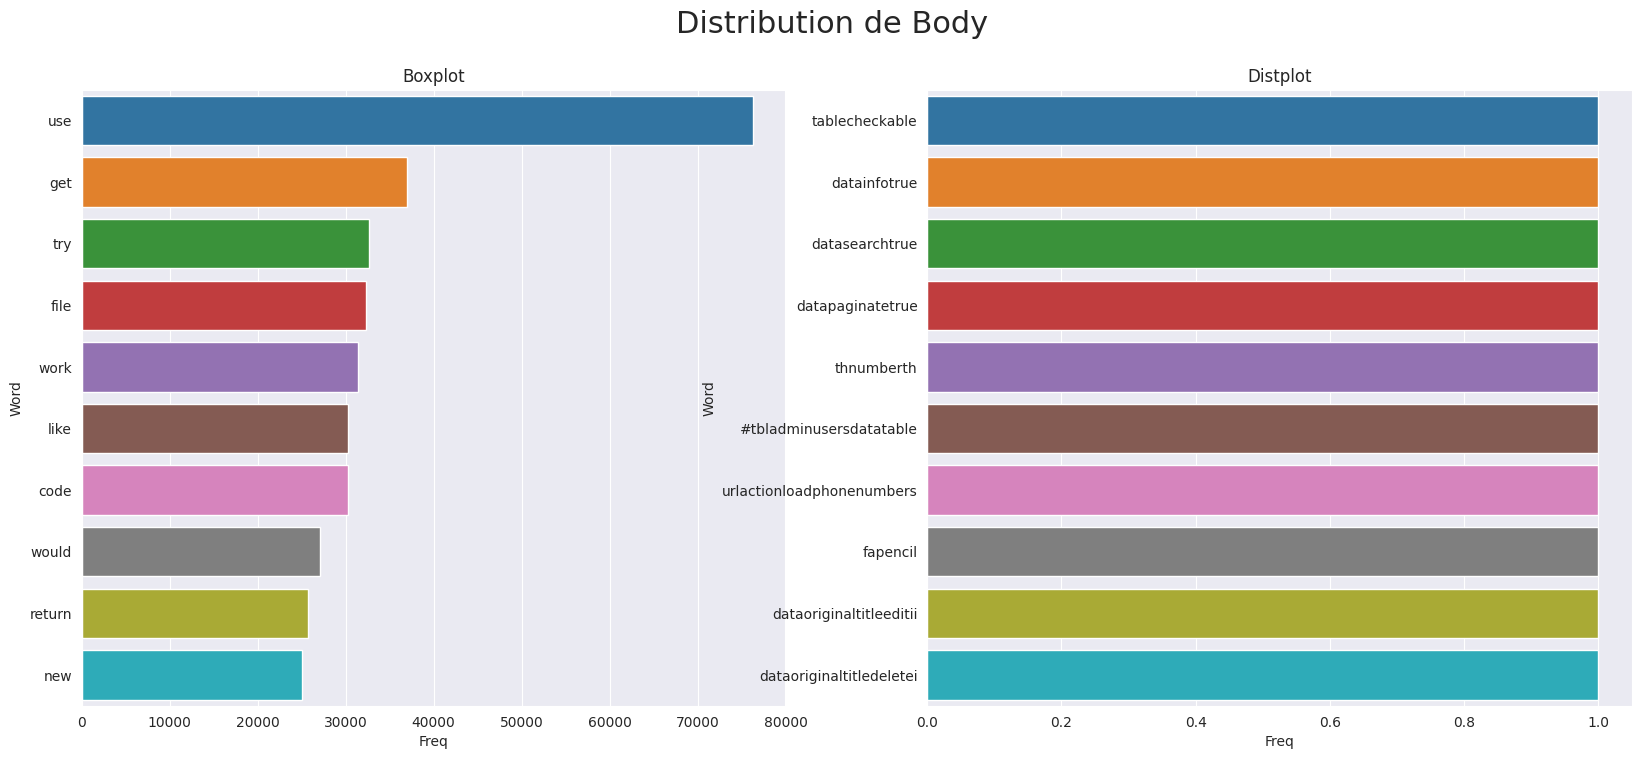

In [50]:
common_rare_words(X_body)

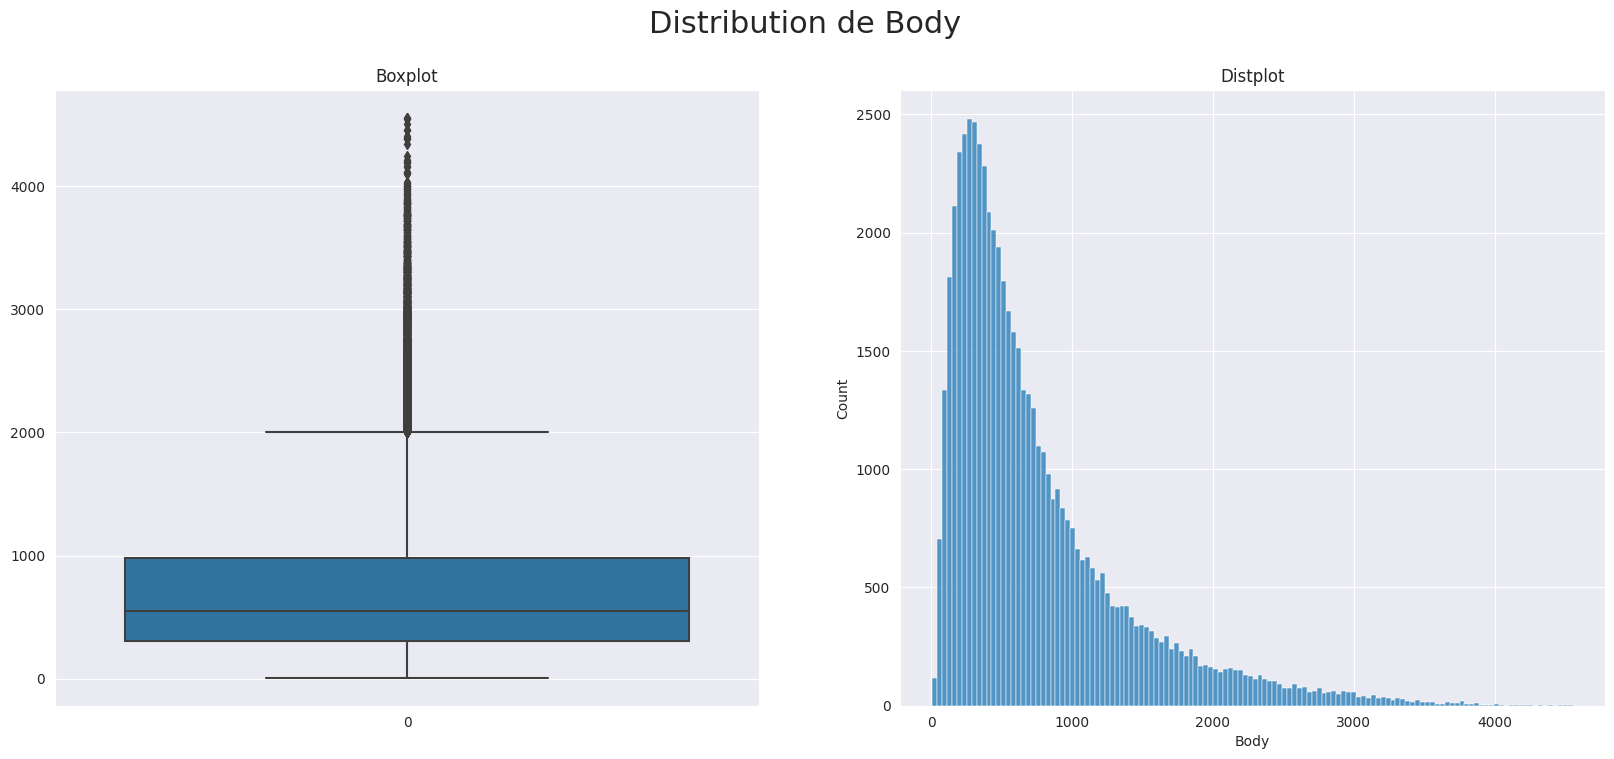

In [51]:
plot_words(X_body)

# Bag of words

In [52]:
SEED = 42

## CountVectorizer simple fit sur title

In [53]:

X_train, X_test = train_test_split(
    X_title, test_size=0.25, random_state=SEED
)
print(X_train.shape, X_test.shape)

(43390,) (14464,)


In [54]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
train_feature = vectorizer.transform(X_train)
test_feature = vectorizer.transform(X_test)

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (43390, 23492), test size : (14464, 23492)


In [55]:
res = pd.DataFrame(train_feature.toarray(), columns=vectorizer.get_feature_names_out())

In [56]:
res.head(1).iloc[: , 99:1000]

accessstoken  accesstoken  accesstokengetaccesstoken  \
0             0            0                          0   

   accessviolationexception  accesswrite  accidentally  accord  accordance  \
0                         0            0             0       0           0   

   accordingly  accordion  ...  architectural  architecture  \
0            0          0  ...              0             0   

   architecturelibrary  architectures  architecturing  archiva  archive  \
0                    0              0               0        0        0   

   archiveddatawithrootobject  archivetar  arcore  
0                           0           0       0  

[1 rows x 901 columns]

In [57]:
# res.head(1).stack()[res.stack() > 0.]

## TF-idf vectorizer simple  fit sur title

In [58]:
tf_vectorizer = TfidfVectorizer()
tf_vectorizer.fit(X_train)
train_feature = tf_vectorizer.transform(X_train)
test_feature = tf_vectorizer.transform(X_test)

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (43390, 23492), test size : (14464, 23492)


In [59]:
p = pd.DataFrame(np.round(train_feature.toarray()[:10, 1000:10000], 2), columns=tf_vectorizer.get_feature_names_out()[1000:10000])

In [60]:
p.stack()[p.stack() > 0.]

0  build              0.29
   ionic              0.37
   ios                0.24
1  crossplatform      0.56
   ios                0.31
2  cause              0.35
   crash              0.35
   ios                0.24
3  command            0.28
   dev                0.40
   disable            0.31
   environment        0.33
4  atomic             0.53
   compiler           0.45
5  curl               0.49
   double             0.46
6  average            0.53
   django             0.35
7  avf                0.40
   avoutputcontext    0.40
   avplayer           0.30
   context            0.25
   error              0.16
8  configurable       0.54
   eclipse            0.33
   hierarchy          0.42
   inconsistent       0.46
9  dll                0.32
   fail               0.23
   file               0.17
   importerror        0.35
dtype: float64

## CountVectorizer simple fit sur title et transform title + body

In [61]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
train_feature = vectorizer.transform(X_train + " " + data.loc[X_train.index]['Body'])
test_feature = vectorizer.transform(X_test + " " + data.loc[X_test.index]['Body'])

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (43390, 23492), test size : (14464, 23492)


## TF-idf vectorizer simple  fit sur title et transform title + body

In [62]:
tf_vectorizer = TfidfVectorizer()
tf_vectorizer.fit(X_train)
train_feature = tf_vectorizer.transform(X_train + " " + data.loc[X_train.index]['Body'])
test_feature = tf_vectorizer.transform(X_test + " " + data.loc[X_test.index]['Body'])

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (43390, 23492), test size : (14464, 23492)


## CountVectorizer simple fit sur title et body

In [63]:
X = X_title + " " + X_body
X_train, X_test = train_test_split(
    X, test_size=0.25, random_state=SEED
)
print(X_train.shape, X_test.shape)

(43390,) (14464,)


In [64]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
train_feature = vectorizer.transform(X_train)
test_feature = vectorizer.transform(X_test)

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (43390, 358201), test size : (14464, 358201)


## TF-idf vectorizer simple  fit sur title et body

In [65]:
tf_vectorizer = TfidfVectorizer()
tf_vectorizer.fit(X_train)
train_feature = tf_vectorizer.transform(X_train)
test_feature = tf_vectorizer.transform(X_test)

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (43390, 358201), test size : (14464, 358201)


In [66]:
m = TfidfVectorizer().fit(X_train)
len(m.vocabulary_)


358201

In [67]:
# df_t = TfidfVectorizer().fit_transform(X_train)
# n = 2
# tops = np.zeros((df_t.shape[0], n), dtype=int) # store the top indices in a new array
# for ind in range(df_t.shape[0]):
#     tops[ind,] = np.argsort(-df_t[ind].toarray())[0, 0:n] # for each row (i.e. document) sort the (inversed, as argsort is ascending) list and slice top n

In [68]:
# tops[0]

In [69]:
# c = [m.transform([word]) for word in m.vocabulary_]

In [70]:
# for i in np.argsort(m.toarray())[::-1][:20]:
#     print(m.vocabulary_[i], c[i])

In [71]:
from sklearn.feature_selection import SelectKBest
tf_vectorizer = TfidfVectorizer()
df_t = tf_vectorizer.fit_transform(X_train)


In [72]:
# df_t_reduced = SelectKBest(k=50).fit_transform(df_t, data.loc[X_train.index]['Tags'])

In [73]:
tf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tf_vectorizer.fit(X_train)
train_feature = tf_vectorizer.transform(X_train)
test_feature = tf_vectorizer.transform(X_test)

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (43390, 2318995), test size : (14464, 2318995)


In [74]:
tf_vectorizer = TfidfVectorizer(max_df=0.9,
                                min_df=1,
                                max_features=1000,
                                use_idf=False,
                                # smooth_idf=True,
                                # sublinear_tf=False,
                                )
tf_vectorizer.fit(X_train)
train_feature = tf_vectorizer.transform(X_train)
test_feature = tf_vectorizer.transform(X_test)

print(f"Train size : {train_feature.shape}, test size : {test_feature.shape}")

Train size : (43390, 1000), test size : (14464, 1000)


Text(0.5, 1.0, 'Sparse Matrix Sample')

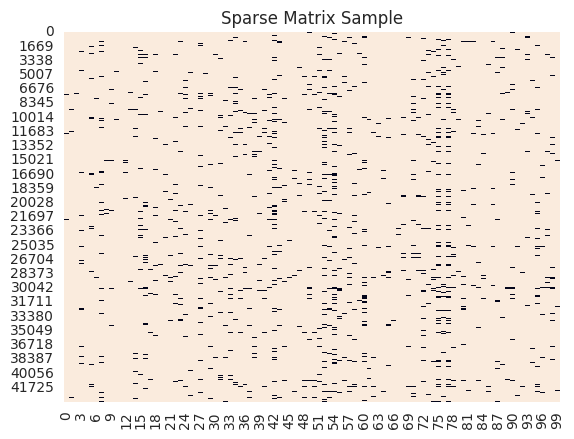

In [75]:
sns.heatmap(train_feature.todense()[:,np.random.randint(0,train_feature.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [76]:
# fig, ax = plt.subplots()
# fig.suptitle("y", fontsize=12)
# data["Tags"].reset_index().groupby("Tags").count().sort_values(by=
#                                                         "index").plot(kind="barh", legend=False,
#                                                                       ax=ax).grid(axis='x')
# plt.show()

In [77]:
data["Title_not_clean"] = df["Title"]
data["Body_not_clean"] = df["Body"]
data.to_parquet('clean_v3.parquet')